# Ethereum Fraud Detection

## Import Packages and Read Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_csv('data/train_accounts.csv')
df_test = pd.read_csv('data/test_accounts.csv')
df_transactions = pd.read_csv('data/transactions.csv')

In [3]:
train_list = df_train.account.to_list()
test_list = df_test.account.to_list()
whole_list = train_list + test_list

print('Training records:', len(train_list), 'Testing records', len(test_list))
print('Total records:', len(whole_list), len(set(whole_list)))

fraud_list = df_train[df_train.flag == 1].account.to_list()
print('Fraud records:', len(fraud_list))

Training records: 25198 Testing records 6300
Total records: 31498 31498
Fraud records: 2455


In [4]:
# Flag Distribution
print(df_train.flag.value_counts())

0    22743
1     2455
Name: flag, dtype: int64


## Exploratory Data Analysis & Preprocessing

In [5]:
print(df_transactions.shape)
print(df_transactions.from_account.nunique(), df_transactions.to_account.nunique())

(5826604, 6)
604847 419535


In [6]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5826604 entries, 0 to 5826603
Data columns (total 6 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   from_account          object
 1   to_account            object
 2   transaction_time_utc  object
 3   value                 object
 4   gas                   int64 
 5   gas_price             int64 
dtypes: int64(2), object(4)
memory usage: 266.7+ MB


In [8]:
df_transactions.tail(3)

,from_account,to_account,transaction_time_utc,value,gas,gas_price
5826601,a20151,b966524,2020-05-04 13:21:32,13000000000000000,21000,10800001235
5826602,a25907,b31505,2020-05-04 13:22:10,0,1500000,12000000000
5826603,a20151,b31501,2020-05-04 13:22:10,0,60000,8470000233


In [10]:
features =   ['src_dst_account_fraud_or_not',
              'src_max_records_by_transaction_date',
              'src_mean_records_by_transaction_date',
              'src_std_records_by_transaction_date',
              'src_max_records_by_transaction_month_year',
              'src_mean_records_by_transaction_month_year',
              'src_std_records_by_transaction_month_year',
              'src_max_records_by_transaction_year',
              'src_mean_records_by_transaction_year',
              'src_std_records_by_transaction_year',
              'src_total_transactions', 'src_year_count',
              'src_token_record_count',
              'src_max_gas', 'src_min_gas', 'src_mean_gas', 'src_std_gas',
              'src_max_gas_price', 'src_min_gas_price',
              'src_mean_gas_price', 'src_std_gas_price',
              'src_max_gas_fee', 'src_min_gas_fee',
              'src_mean_gas_fee', 'src_std_gas_fee',
              'src_max_value_digit', 'src_min_value_digit',
              'src_mean_value_digit', 'src_std_value_digit',
              'dst_max_records_by_transaction_date',
              'dst_mean_records_by_transaction_date',
              'dst_std_records_by_transaction_date',
              'dst_max_records_by_transaction_month_year',
              'dst_mean_records_by_transaction_month_year',
              'dst_std_records_by_transaction_month_year',
              'dst_max_records_by_transaction_year',
              'dst_mean_records_by_transaction_year',
              'dst_std_records_by_transaction_year',
              'dst_total_transactions', 'dst_year_count',
              'dst_token_record_count',
              'dst_max_gas', 'dst_min_gas', 'dst_mean_gas', 'dst_std_gas',
              'dst_max_gas_price', 'dst_min_gas_price',
              'dst_mean_gas_price', 'dst_std_gas_price',
              'dst_max_gas_fee', 'dst_min_gas_fee',
              'dst_mean_gas_fee', 'dst_std_gas_fee',
              'dst_max_value_digit', 'dst_min_value_digit',
              'dst_mean_value_digit', 'dst_std_value_digit']

df_all = pd.read_pickle('data/df_all_part3.pkl')
print(len(features))

57


In [11]:
import matplotlib.pyplot as plt
import seaborn as sn

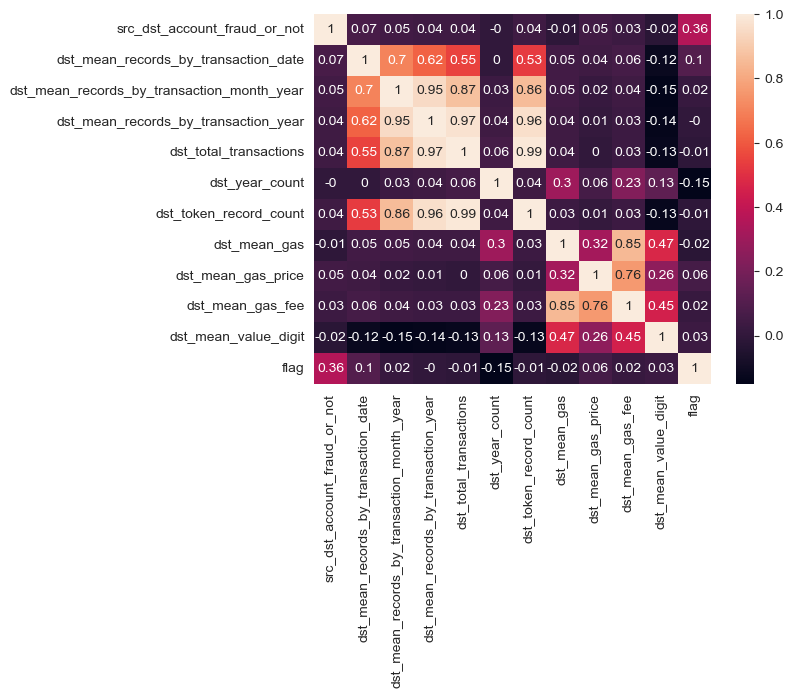

In [15]:
selected_features = ['src_dst_account_fraud_or_not',
                     'dst_mean_records_by_transaction_date',
                     'dst_mean_records_by_transaction_month_year',
                     'dst_mean_records_by_transaction_year',
                     'dst_total_transactions',
                     'dst_year_count',
                     'dst_token_record_count',
                     'dst_mean_gas',
                     'dst_mean_gas_price',
                     'dst_mean_gas_fee',
                     'dst_mean_value_digit',
                     'flag']

train_data = pd.read_pickle('data/train_data.pkl')
train_data = train_data[selected_features]

corr_matrix = round(train_data.corr(), 2)
sn.heatmap(corr_matrix, annot=True)
plt.savefig('train_dst_correlation.png')
plt.show()

C:\Users\Letian YU\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Probability')

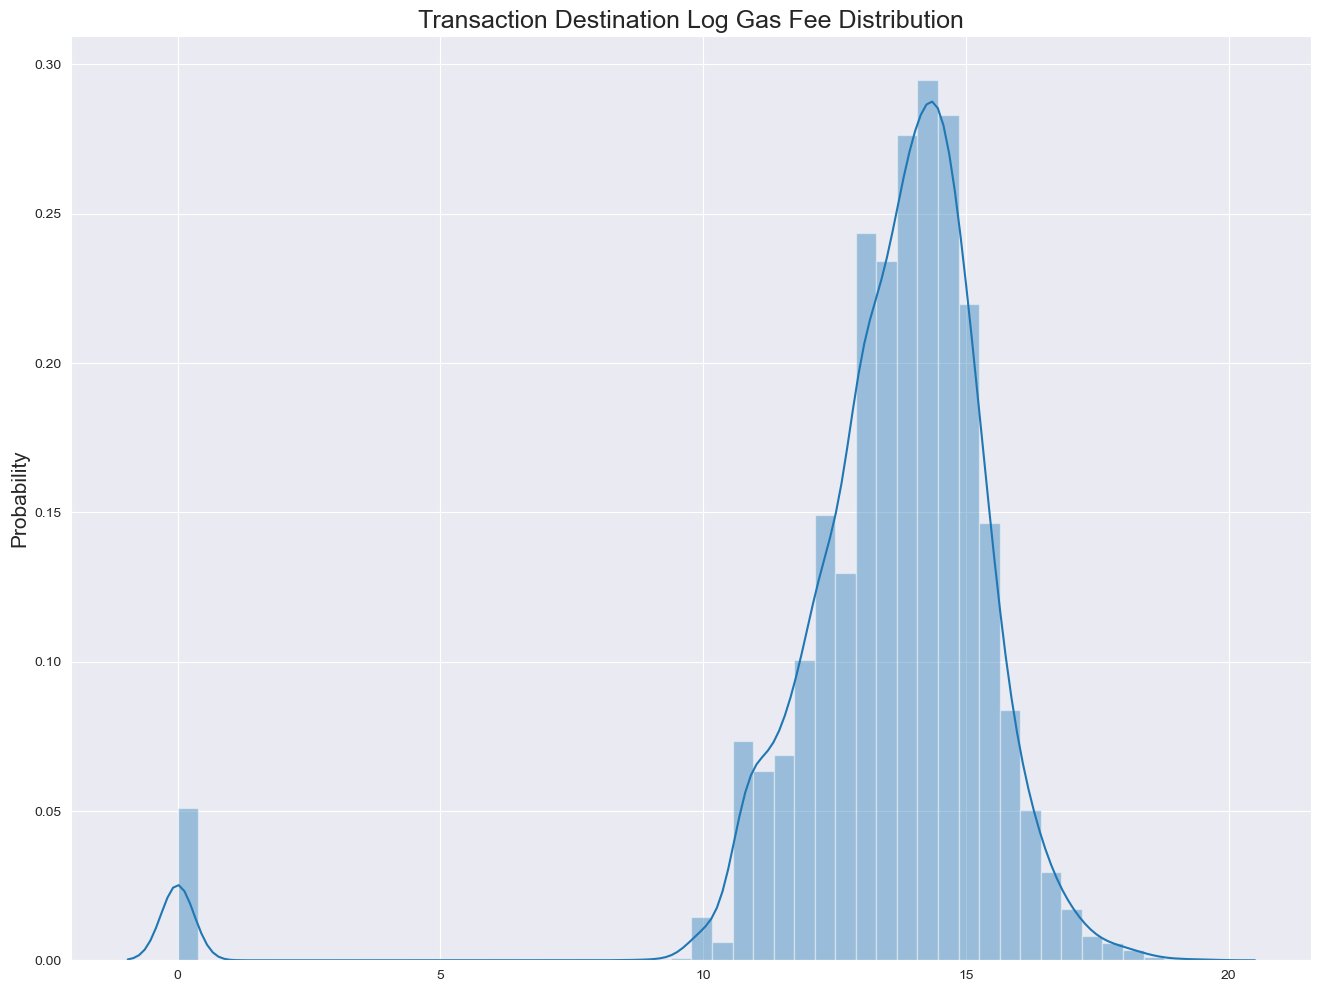

In [18]:
plt.figure(figsize=(16,12))
g = sn.distplot(train_data.dst_mean_gas_fee)
g.set_title("Transaction Destination Log Gas Fee Distribution", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=15)

In [19]:
from sklearn.manifold import TSNE

C:\Users\Letian YU\AppData\Local\Temp\ipykernel_18252\1942036859.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
C:\Users\Letian YU\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Letian YU\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


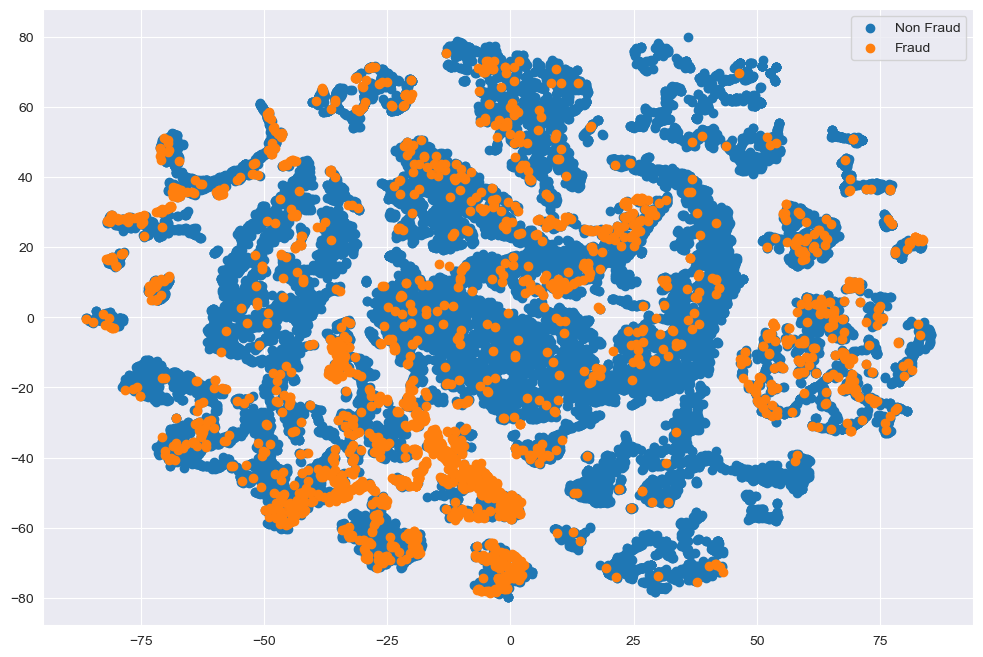

In [20]:
train_data = pd.read_pickle('data/train_data.pkl')
non_fraud = train_data[train_data['flag'] == 0].drop(columns='account')
fraud = train_data[train_data['flag'] == 1].drop(columns='account')

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['flag'], axis = 1).values
Y = df["flag"].values

def tsne_plot(x1, y1):
    tsne = TSNE(n_components=2, random_state=42)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], label='Fraud')

    plt.legend();
    plt.show();

tsne_plot(X, Y)

In [21]:
import joblib
grid_search = joblib.load('model/XGBoost_grid_5.pkl')

C:\Users\Letian YU\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [23]:
print(grid_search.best_estimator_.feature_importances_)

[0.14052063 0.01151184 0.01212077 0.00828501 0.00898163 0.00716142
 0.01264319 0.01478778 0.01027501 0.03508274 0.01796303 0.01366409
 0.01224645 0.02062977 0.01328987 0.04187186 0.01277181 0.0101485
 0.0096469  0.00709763 0.01005073 0.00716043 0.00685676 0.00669332
 0.00967427 0.01550295 0.0461484  0.00833841 0.0115836  0.00741287
 0.07592208 0.01209538 0.01133424 0.01436414 0.02734143 0.01450829
 0.00756256 0.02523237 0.02009119 0.06010669 0.01124499 0.01068071
 0.02304095 0.01225326 0.01211035 0.00716203 0.00604765 0.00599264
 0.01484699 0.0067994  0.00727753 0.00632124 0.01247563 0.01204326
 0.00694623 0.01116299 0.01491417]


In [38]:
feature_importance_list = grid_search.best_estimator_.feature_importances_.tolist()
feature_list = features

feature_imp = pd.DataFrame({'feature': features, 'importance': feature_importance_list})
feature_imp = feature_imp.sort_values(by='importance', ascending=False)
feature_imp

,feature,importance
0,src_dst_account_fraud_or_not,0.140521
30,dst_mean_records_by_transaction_date,0.075922
39,dst_year_count,0.060107
26,src_min_value_digit,0.046148
15,src_mean_gas,0.041872
9,src_std_records_by_transaction_year,0.035083
34,dst_std_records_by_transaction_month_year,0.027341
37,dst_std_records_by_transaction_year,0.025232
42,dst_min_gas,0.023041
13,src_max_gas,0.020630


AttributeError: 'function' object has no attribute 'get_score'

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

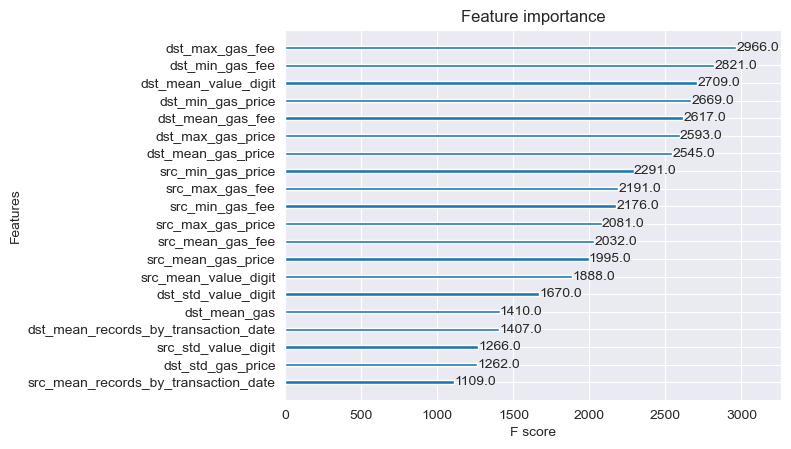

In [41]:
from xgboost import plot_importance, plot_tree

plot_importance(grid_search.best_estimator_, max_num_features=20)